# Exemplary analysis of the PBMC3K single-cell RNA dataset

Dependencies

- scanpy==1.7.2
- anndata==0.7.6
- umap==0.5.1
- nmpy==1.19.4
- scipy==1.5.3
- pandas==1.1.4
- scikit-learn==0.23.2
- statsmodels==0.12.1
- python-igraph==0.9.1
- louvain==0.7.0


In [12]:
from typing import Optional
import csv
import scanpy as sc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

rawdata_dir = os.path.join(os.getcwd(), "rawdata")
figure_dir = "/home/jovyan/work/figures"

# Global settings
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.9.1 louvain==0.7.0


In [13]:
adata = sc.read_10x_mtx(rawdata_dir, var_names="gene_symbols", cache=False)
adata.var_names_make_unique()

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

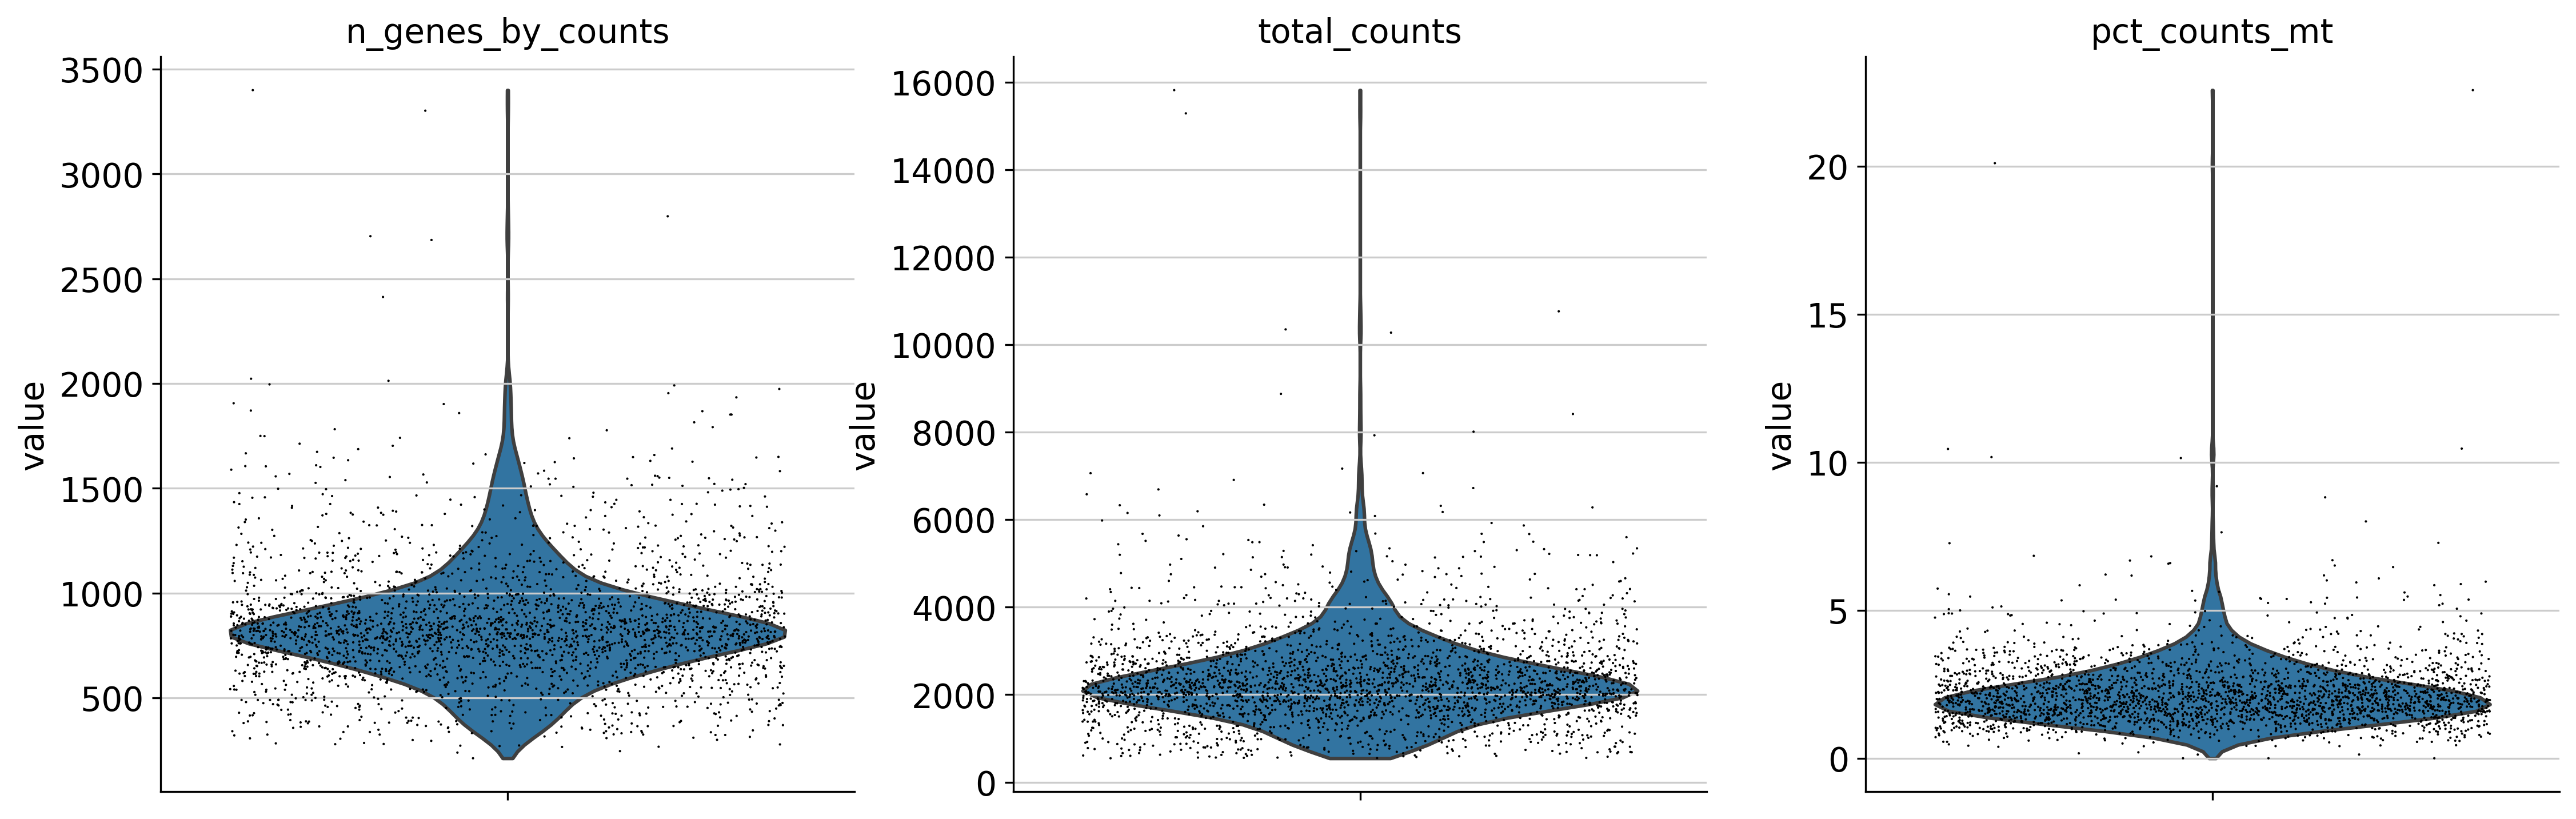

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [17]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

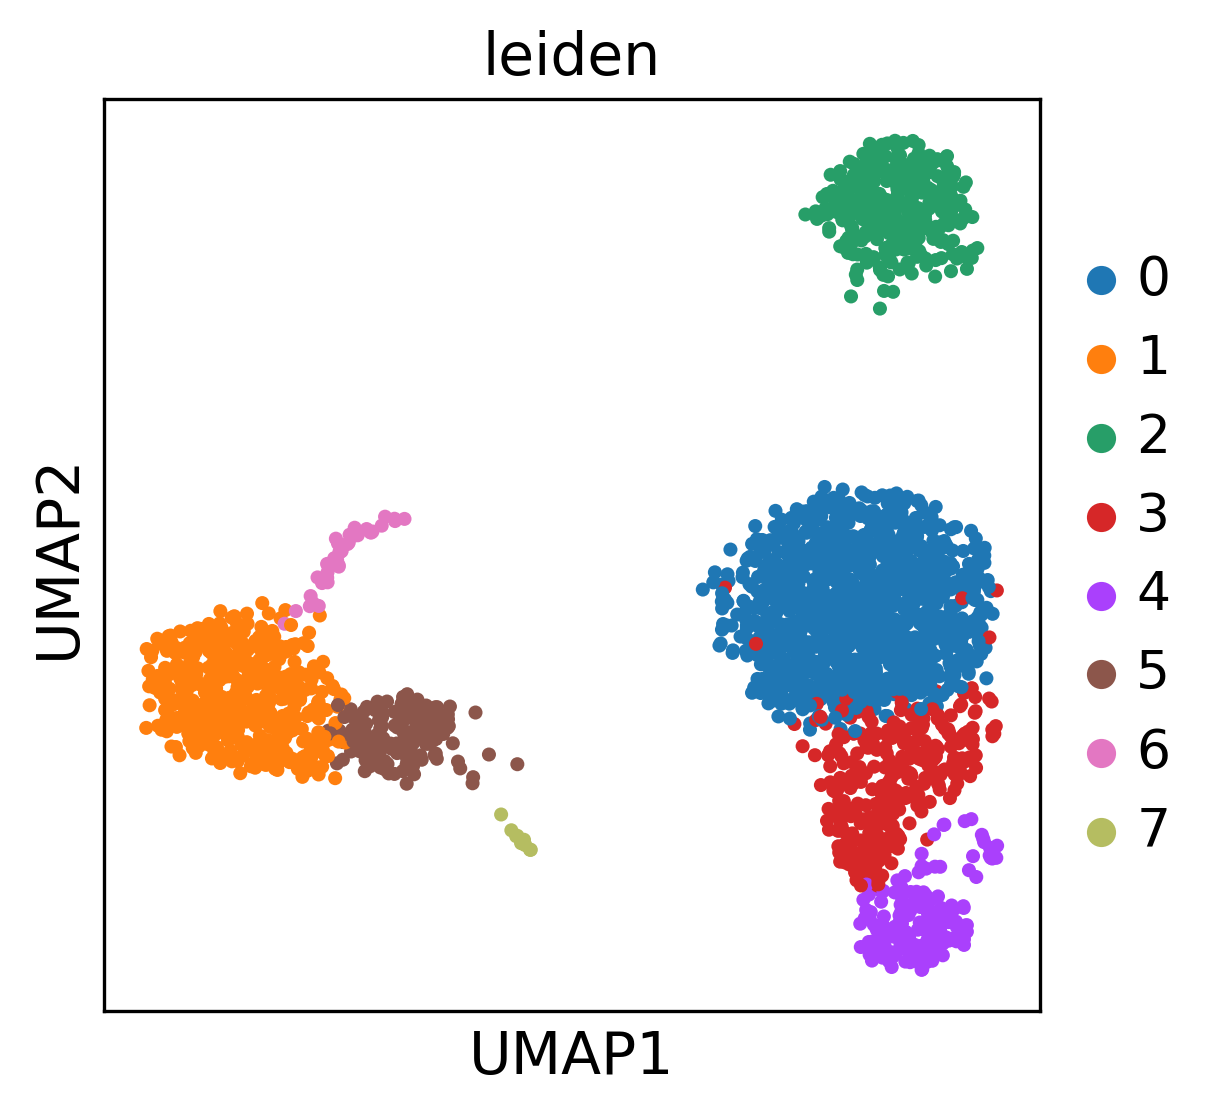

In [21]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

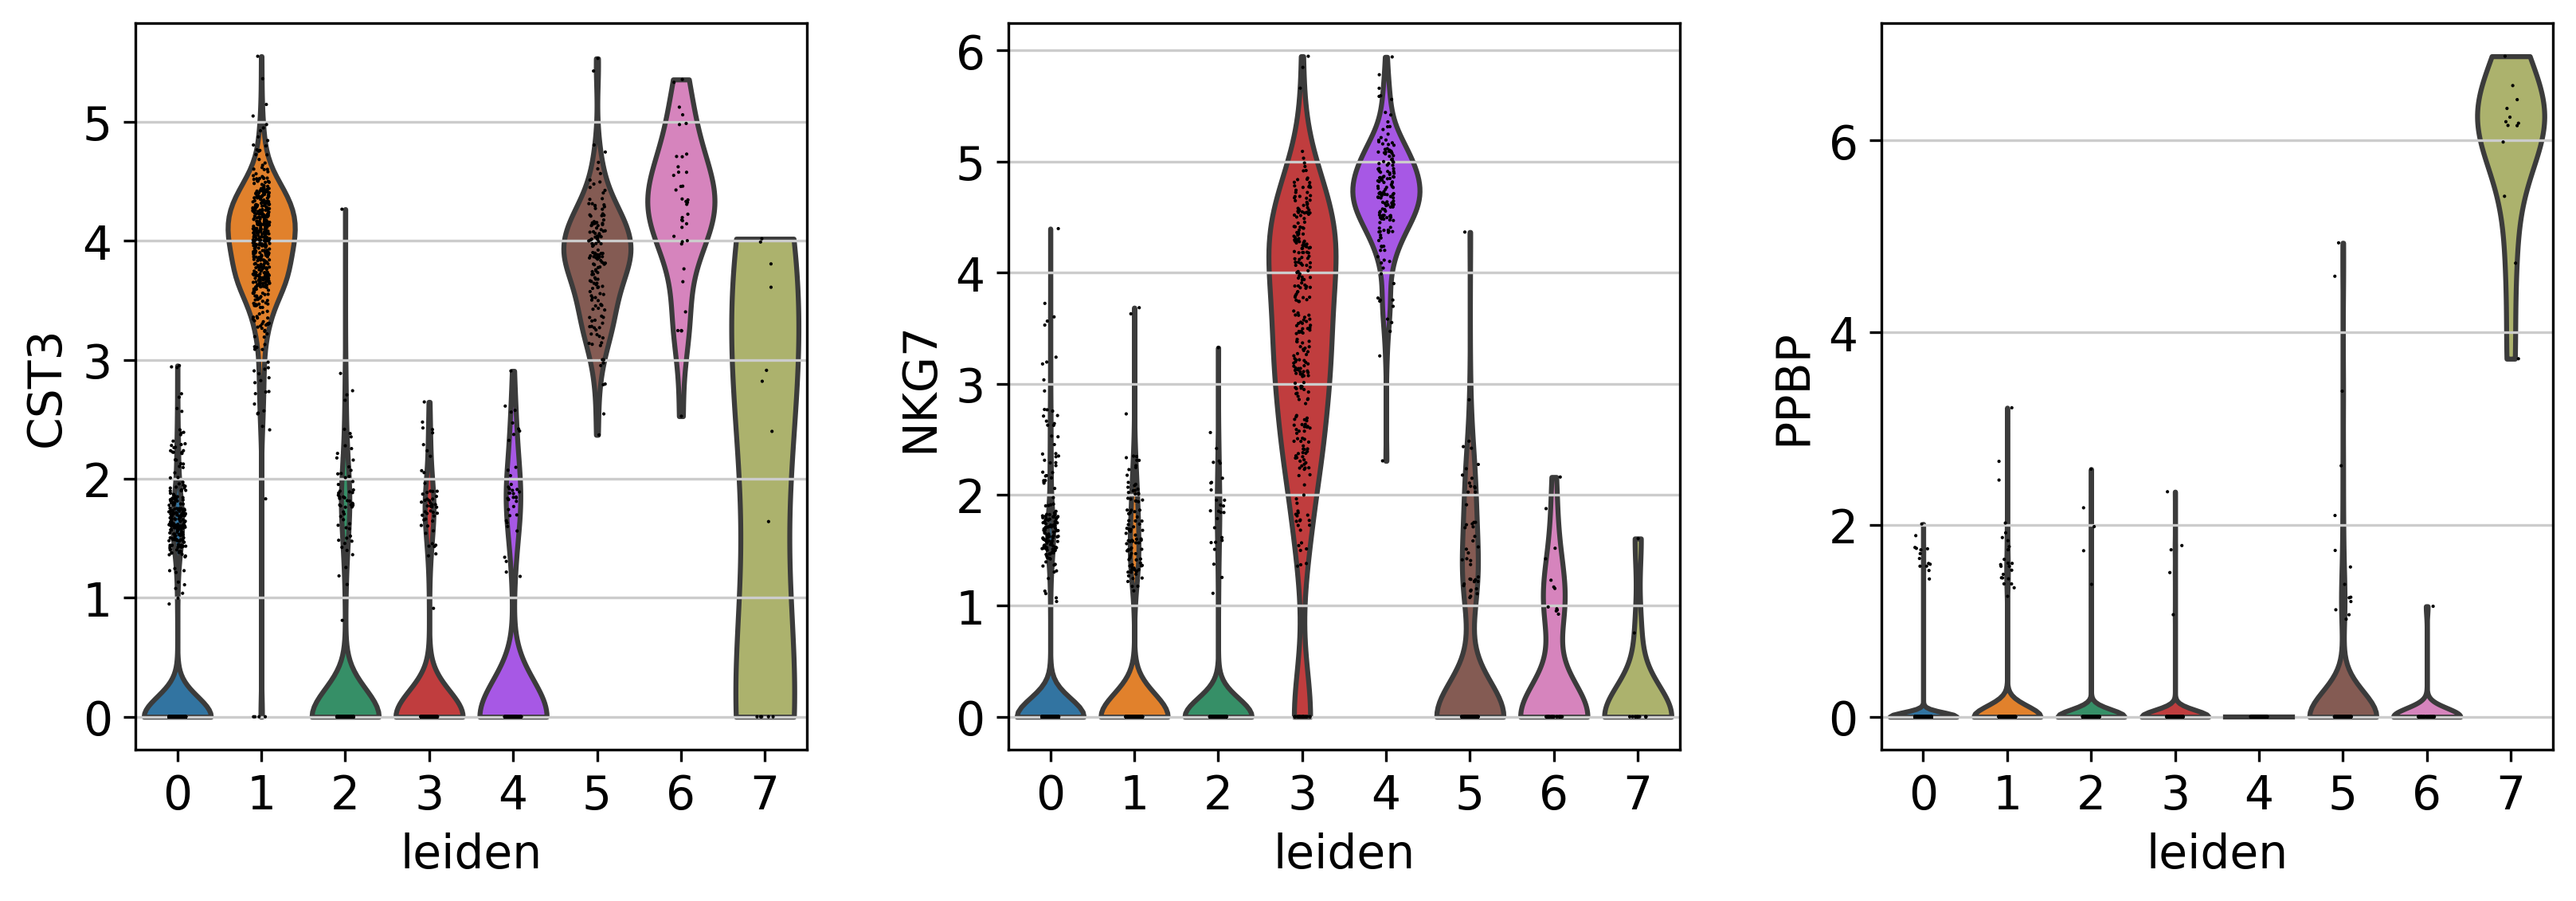

In [22]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

### Rename leiden clusters

In [23]:
new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]
adata.rename_categories('leiden', new_cluster_names)

### Generate final figure versions for paper

* marker genes violin plot
* UMAP plot with cluster annotation

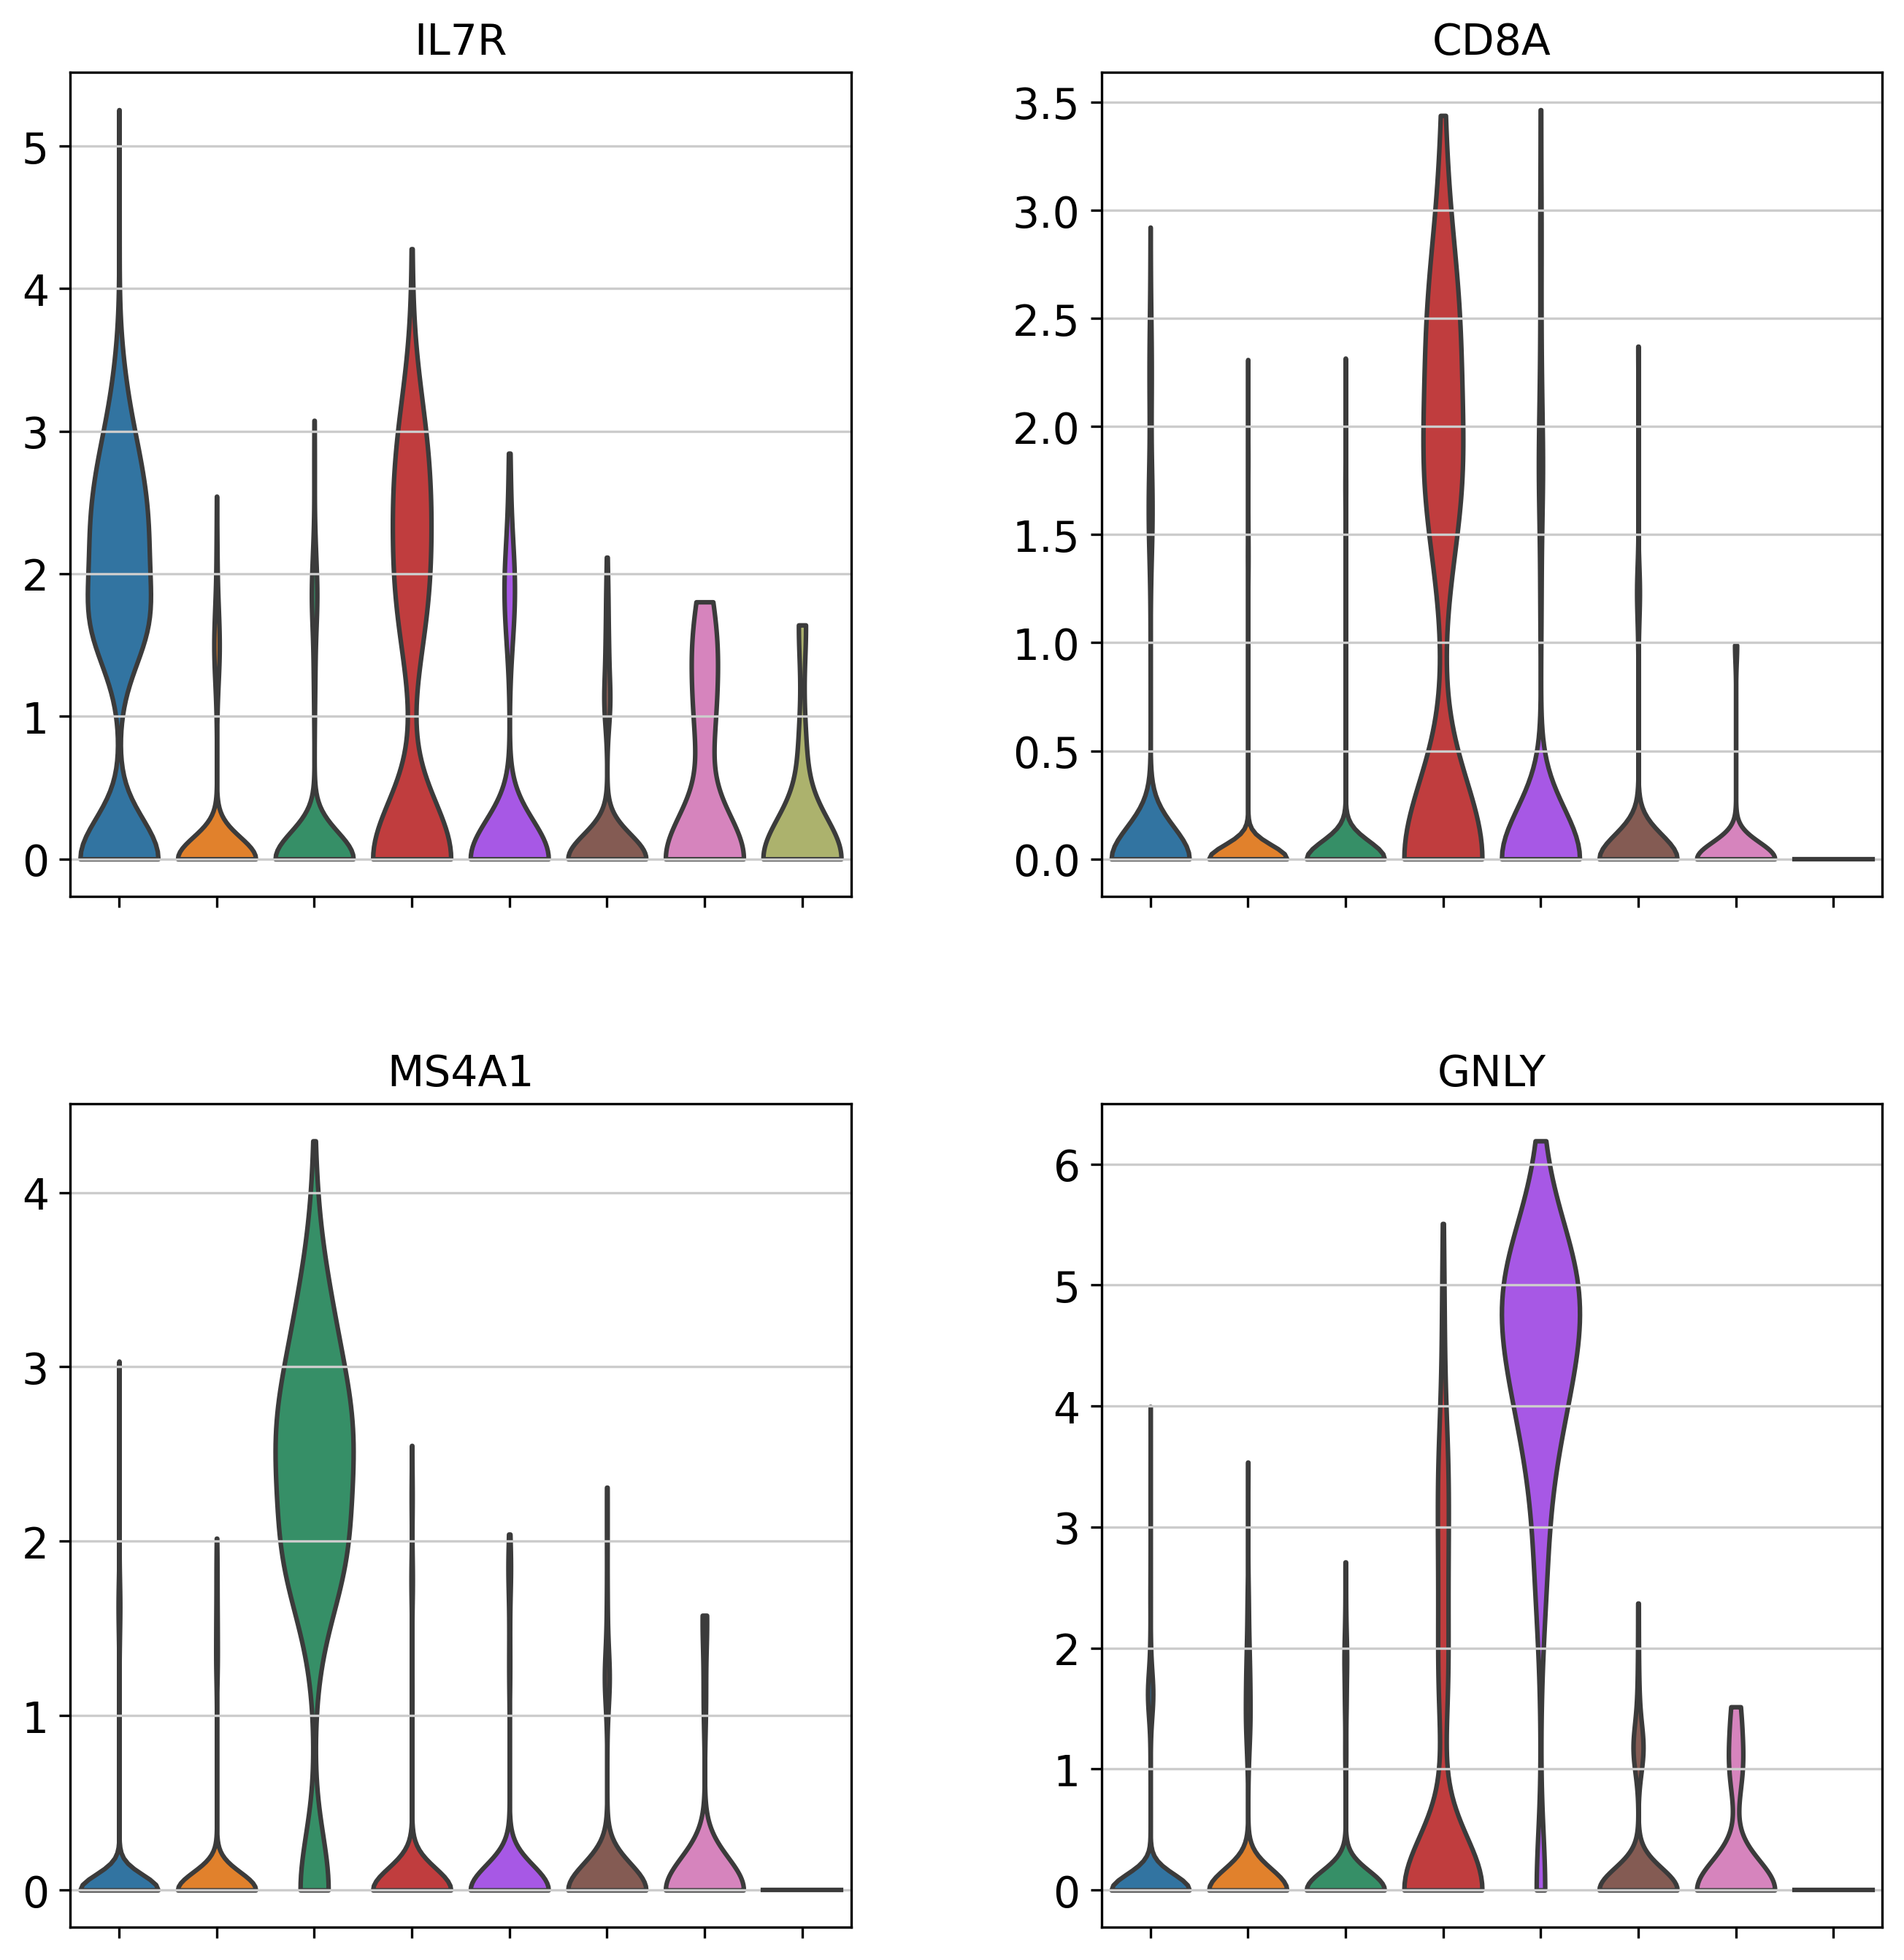

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.tight_layout(pad=3.0)
for index, gene in enumerate(["IL7R", "MS4A1", "CD8A", "GNLY"]):
    x_pos = index % 2
    y_pos = math.floor(index / 2)

    sc.pl.violin(adata, gene, groupby='leiden', jitter=False, size=0, show=False, ax=ax[x_pos, y_pos])
    ax[x_pos, y_pos].set_title(gene)
    ax[x_pos, y_pos].set_xticklabels([])
    ax[x_pos, y_pos].set_ylabel("")
    ax[x_pos, y_pos].set_xlabel("")

plt.savefig(os.path.join(figure_dir, "figure3.png"))


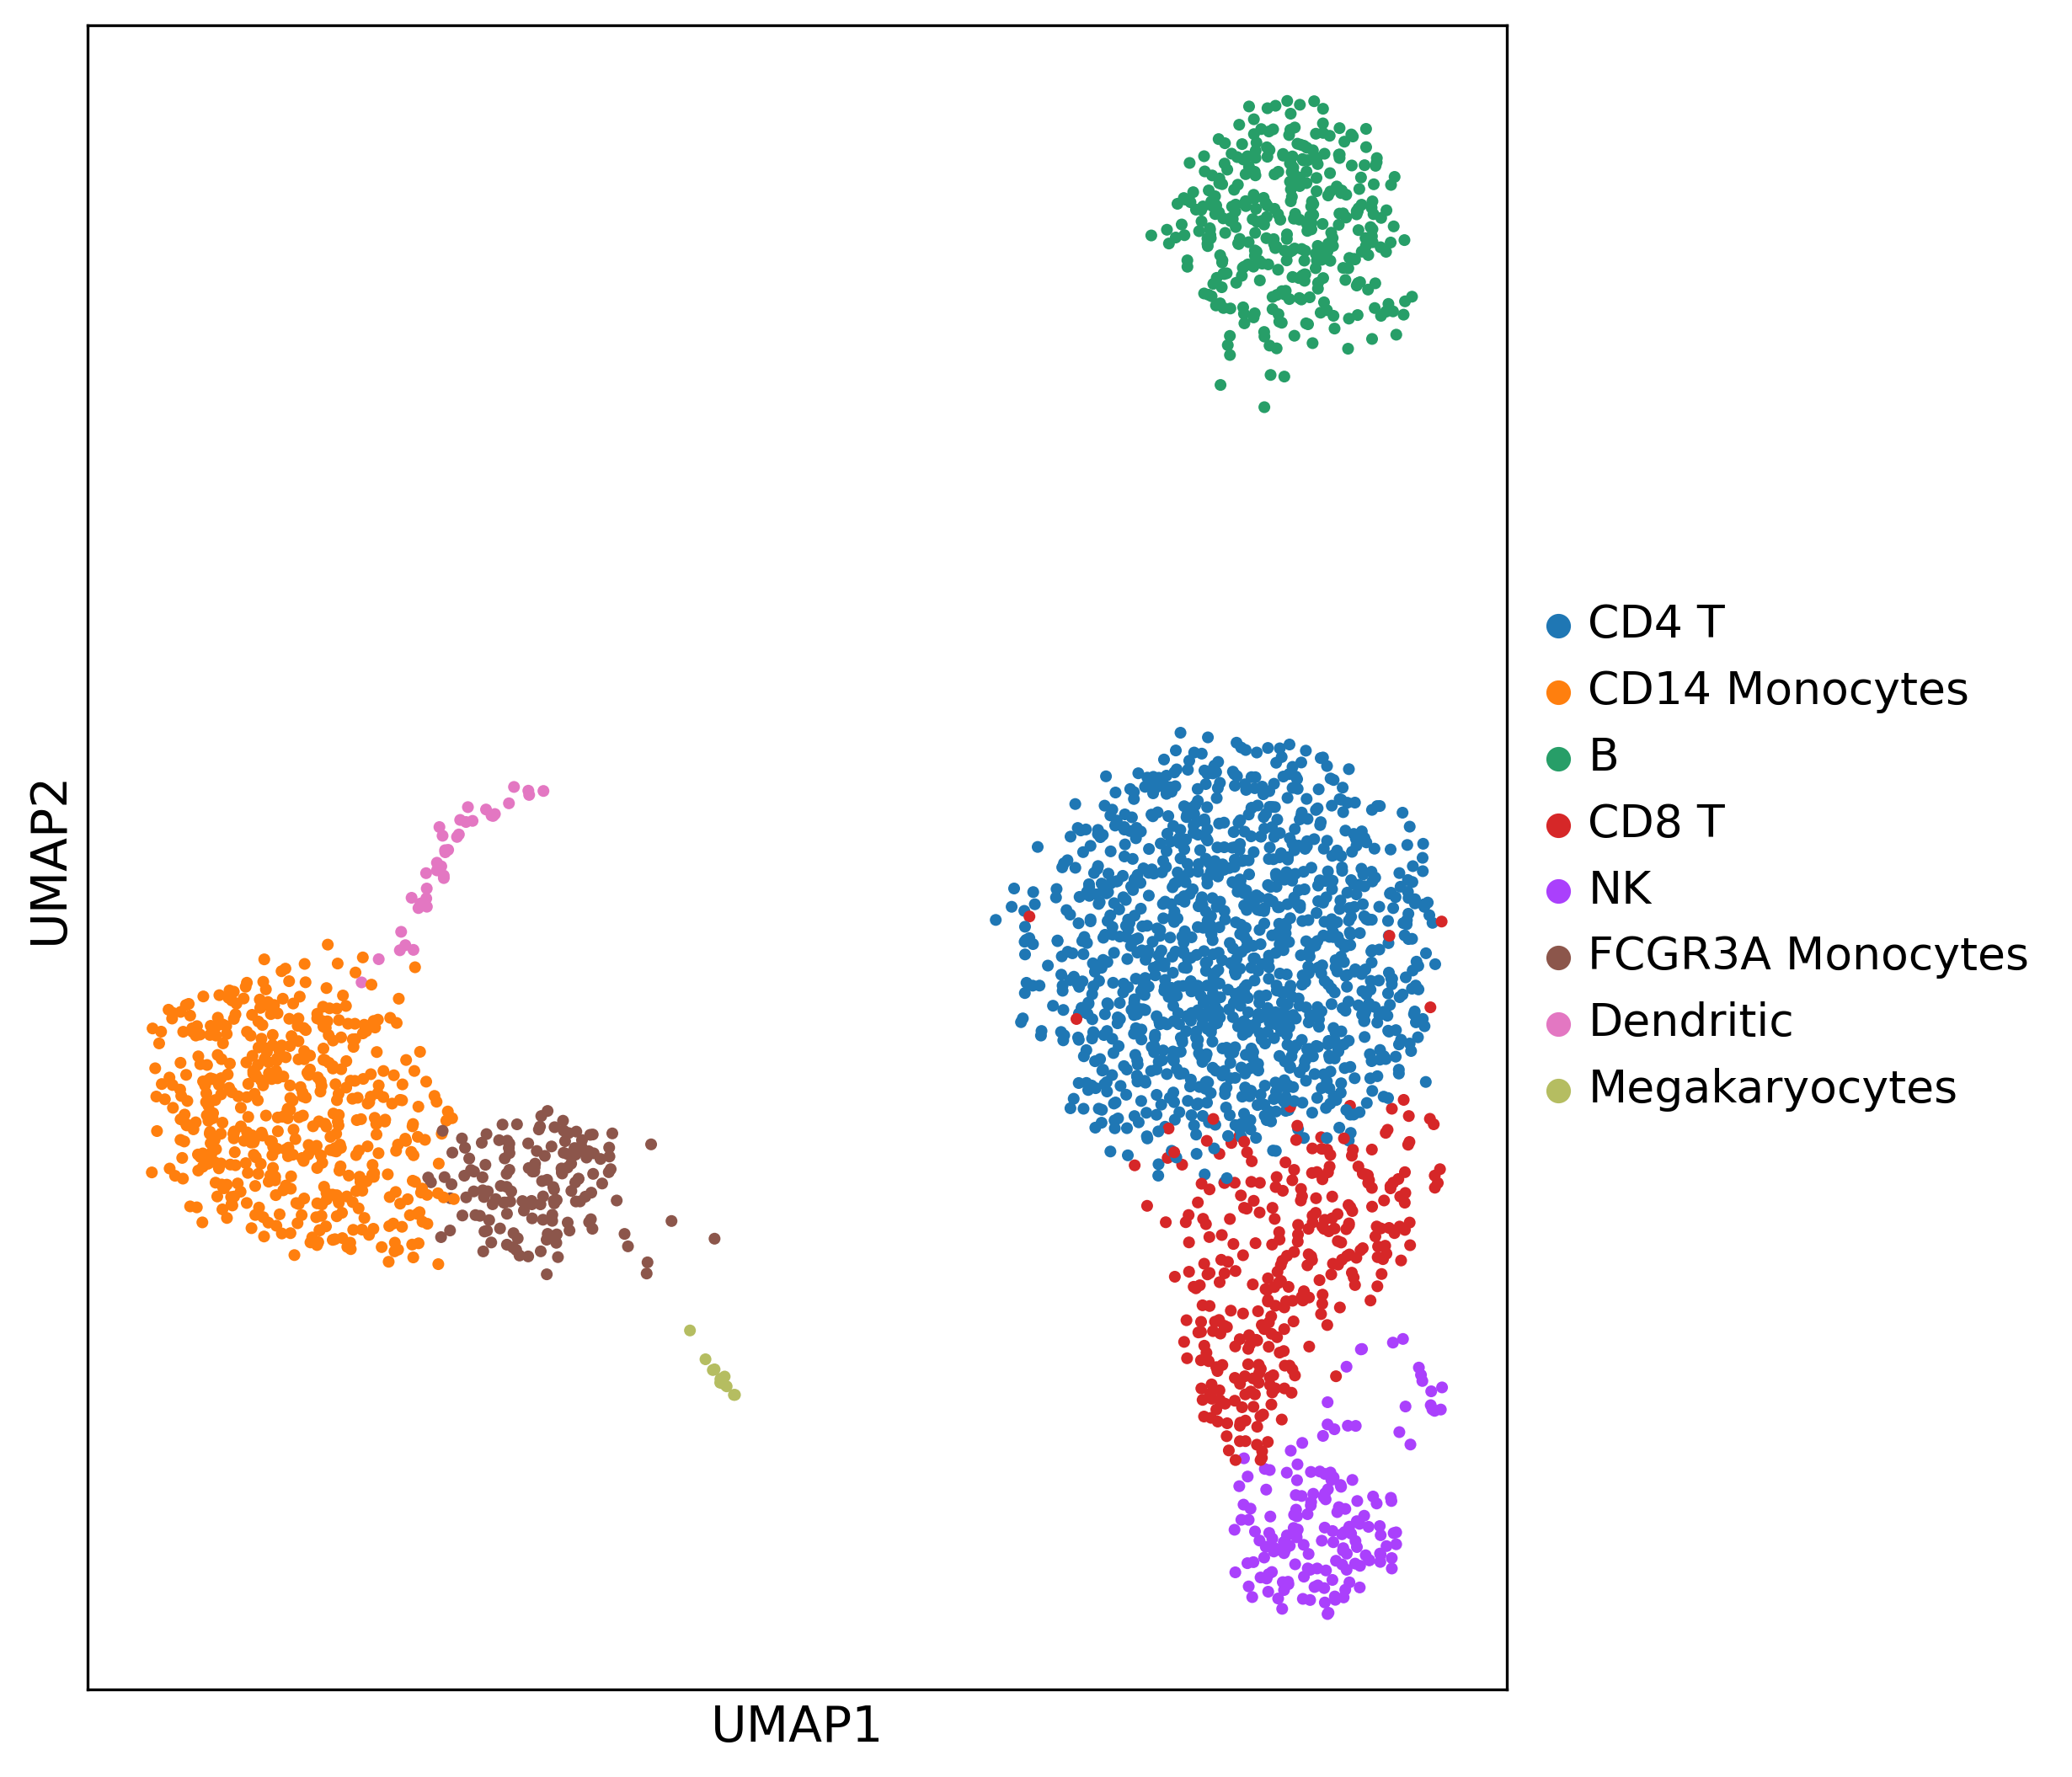

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.set_aspect('equal', adjustable='box')
sc.pl.umap(adata, color='leiden', legend_loc='right margin', title='', frameon=True, ax=ax, show=False)
plt.tight_layout(pad=3.0)

plt.savefig(os.path.join(figure_dir, "figure2.png"))

### Differential analysis results to pandas dataframe

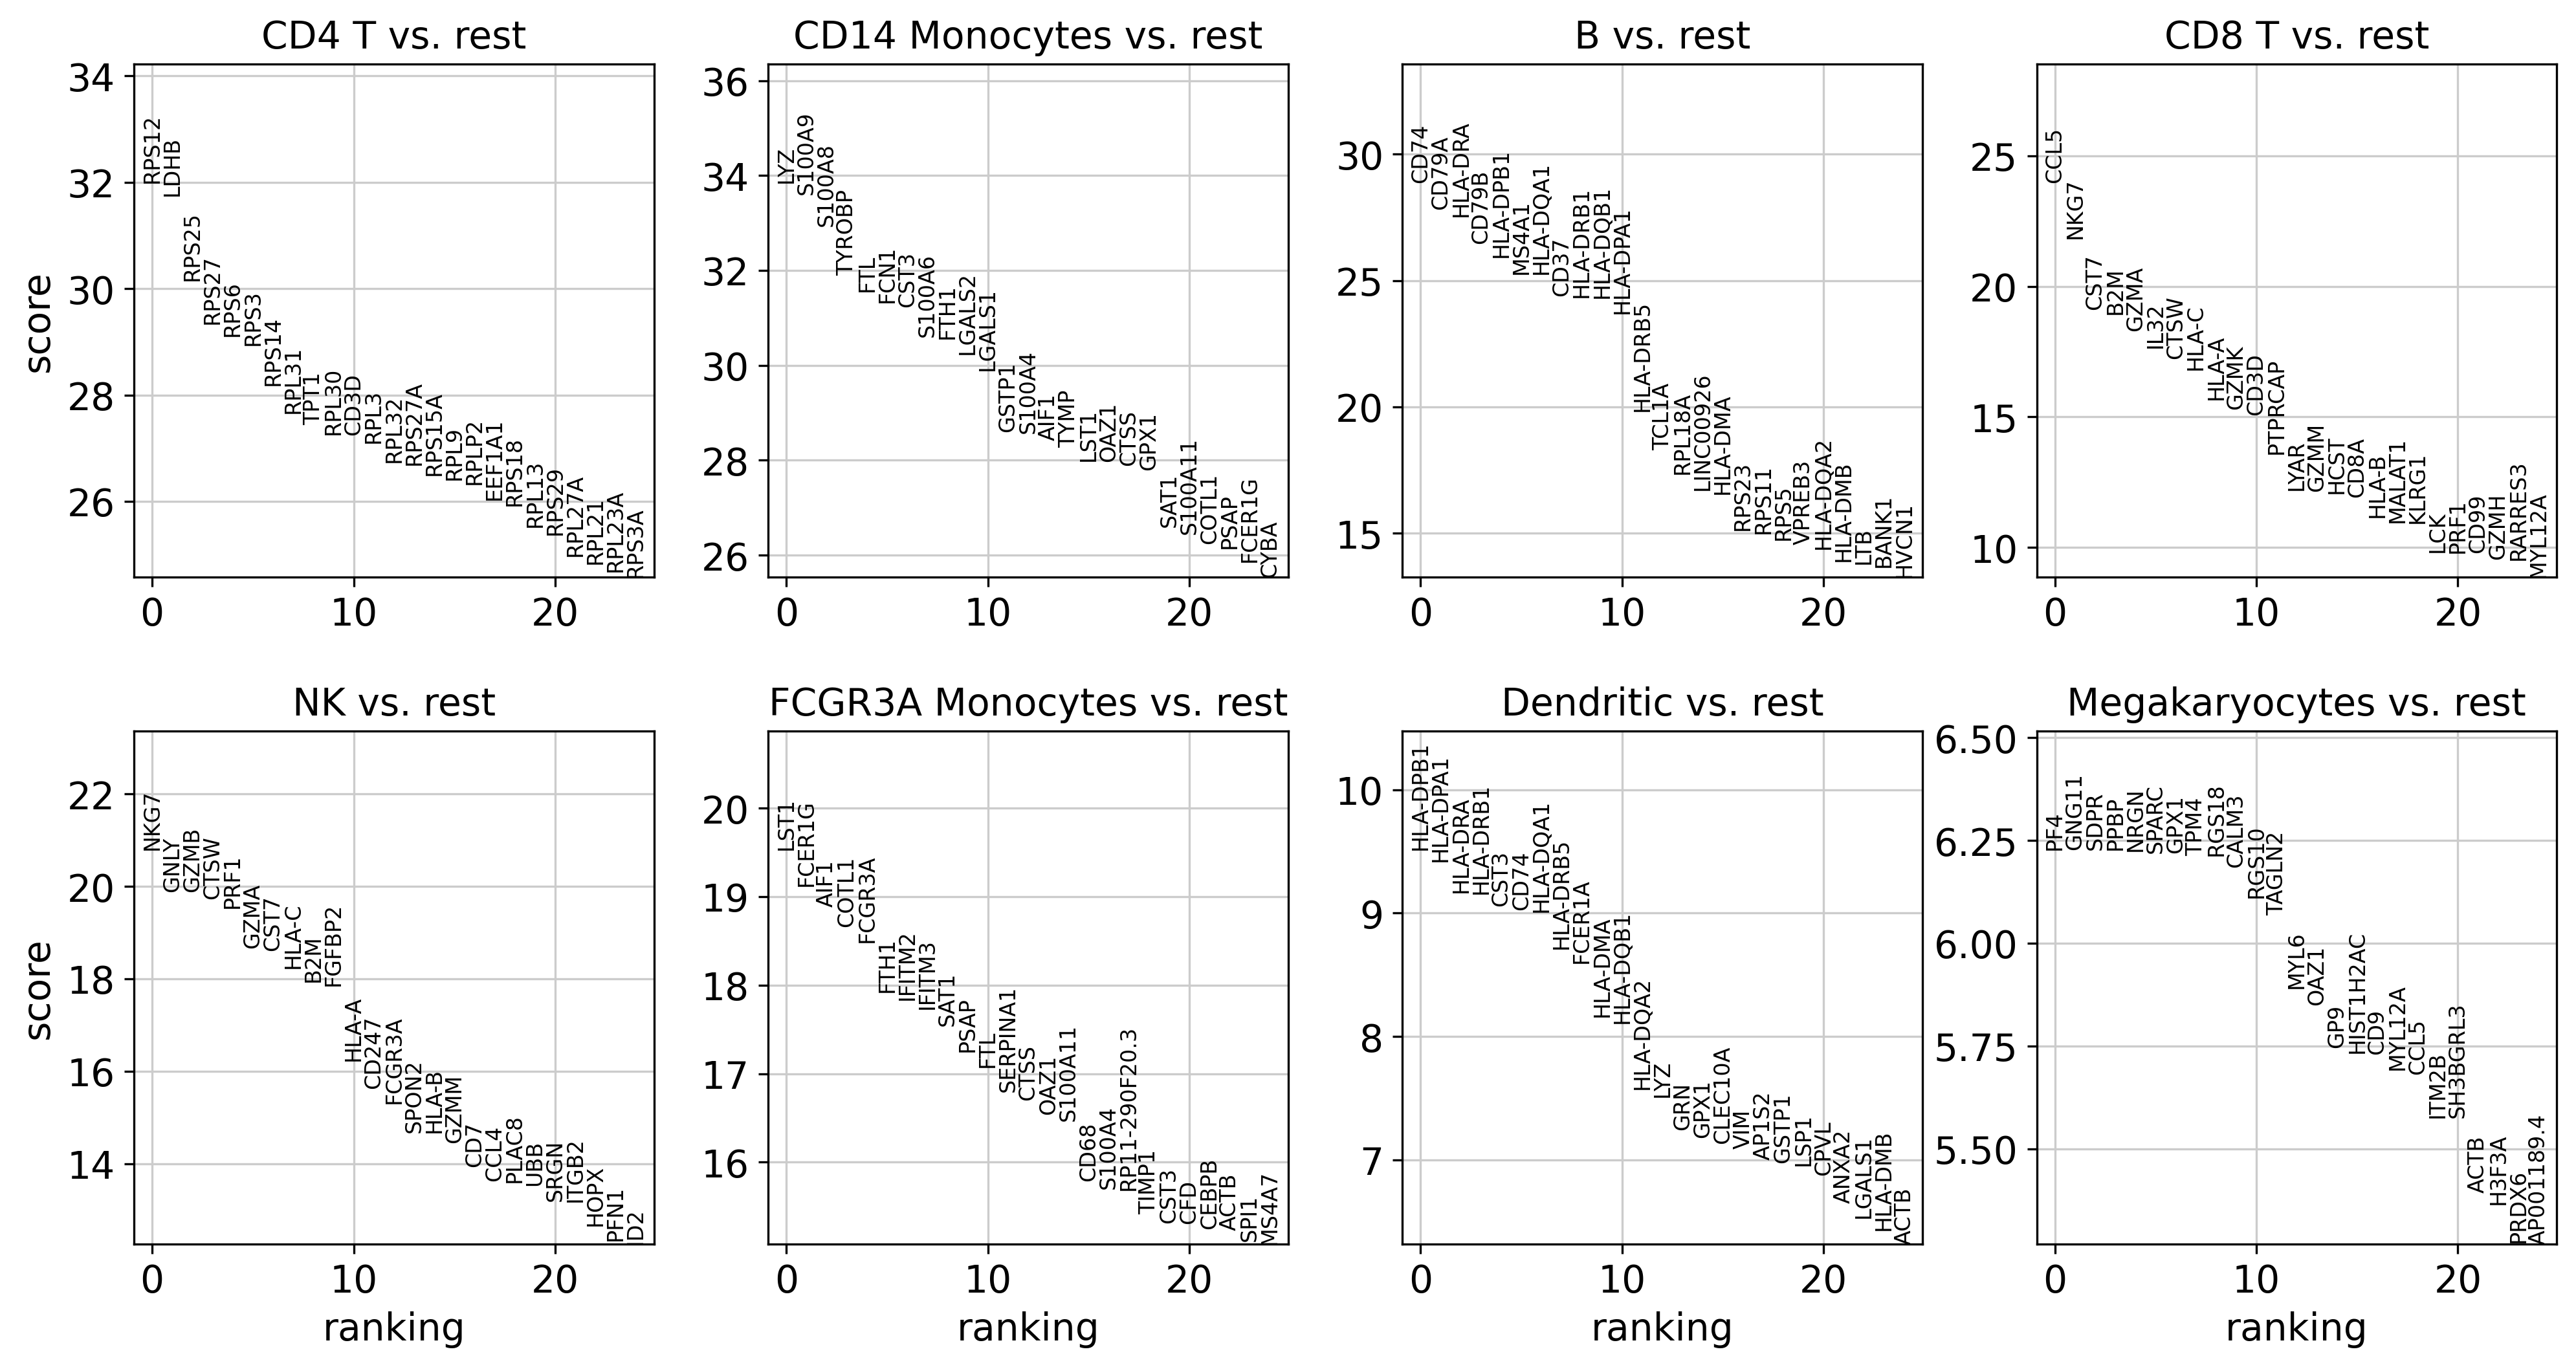

,CD4 T,CD14 Monocytes,B,CD8 T,NK,FCGR3A Monocytes,Dendritic,Megakaryocytes
0,RPS12,LYZ,CD74,CCL5,NKG7,LST1,HLA-DPB1,PF4
1,LDHB,S100A9,CD79A,NKG7,GNLY,FCER1G,HLA-DPA1,GNG11
2,RPS25,S100A8,HLA-DRA,CST7,GZMB,AIF1,HLA-DRA,SDPR
3,RPS27,TYROBP,CD79B,B2M,CTSW,COTL1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,PRF1,FCGR3A,CST3,NRGN


In [26]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=100)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [27]:
def export_uns_data(adata_obj,
                    descriptor: Optional[str] = "rank_genes_groups",
                    filename: Optional[str] = None,
                    basedir: Optional[str] = None,
                    extract_cols=["names", "pvals", "pvals_adj", "logfoldchanges"],
                    overwrite=False):
    
    if not basedir:
        basedir = os.getcwd()
    
    # descriptor = "rank_genes_groups"
    print(f"Exporting differential expression data for '{descriptor}'\n" + \
         "\n".join([f"\t{key}: {value}" for key, value in adata_obj.uns[descriptor]["params"].items()]))

    n_clusters = len(adata_obj.uns[descriptor]["names"][0])
    n_clusters

    data = {"cluster": []}
    for col in extract_cols:
        data[col] = []

    results_df = pd.DataFrame(data)

    items_per_cluster = len(np.array([list(i) for i in np.array(adata_obj.uns[descriptor][extract_cols[0]])])[:,0])

    for cluster in range(0, n_clusters):

        data = {"cluster": []}
        for col in extract_cols:
            data[col] = []

        df = pd.DataFrame(data)

        df["cluster"] = pd.array([cluster] * items_per_cluster, dtype="Int32")

        for col in extract_cols:
            cluster_vars = np.array([list(i) for i in np.array(adata_obj.uns[descriptor][col])])[:,cluster]
            df[col] = cluster_vars

        results_df = results_df.append(df)
        
    if filename:
        # return results_df
        full_filename = os.path.join(basedir, filename)
        if os.path.isfile(full_filename) and not overwrite:
            raise FileExistsError(f"File {full_filename} already exists")

        results_df.to_csv(full_filename, index=False)
        
    return results_df

In [28]:
diffexp_df = export_uns_data(adata, filename="export_uns.csv", overwrite=True)
diffexp_df.head()

Exporting differential expression data for 'rank_genes_groups'
	groupby: leiden
	reference: rest
	method: wilcoxon
	use_raw: True
	layer: None
	corr_method: benjamini-hochberg


,cluster,names,pvals,pvals_adj,logfoldchanges
0,0,RPS12,1.238286e-224,1.698185e-220,1.044792
1,0,LDHB,2.520407e-221,1.728243e-217,2.677442
2,0,RPS25,7.723960e-200,2.118528e-196,1.165159
3,0,RPS27,3.232559e-189,6.333044e-186,1.018170
4,0,RPS6,2.474817e-186,4.242454e-183,0.868466


### Perform KEGGTOOLS enrichment analysis

In [29]:
# KEGGTOOLS imports

# TODO